# Steinschlagrisiko cwm1

## Aufgabenstellung
Die Kantonsstrasse unterhalb Schiers (GR) ist vom Steinschlag betroffen. Steine lösen sich von zwei unterschiedlichen Stellen an der Felswand ab (Ablösungszone 1 und Ablösungszone 2). Der betroffene Strassenabschnitt ist mit Steinfangnetzen gesichert, die jedoch in die Jahre gekommen sind und die angestrebte Sicherheit nicht mehr gewährleisten können. Die Planung für Ersatznetze hat bereits begonnen, kann aber frühstens in einem Jahr umgesetzt werden.

In den letzten Monaten haben sich mehrere Steinschlagereignisse ereignet. Kommt es im Lauf des nächsten Jahres zu weiteren vergleichbaren Ereignissen, könnten die alten Sicherheitsnetze versagen und die Verkehrsteilnehmer einem grossen Sicherheitsrisiko ausgesetzt sein. Die Bevölkerung ist verunsichert und der Kantonsingenieur muss schnell entscheiden, ob das Risiko für die Verkehrsteilnehmer zu gross ist und die Kantonsstrasse vorübergehend gesperrt werden muss. Der Kantonsingenieur hat sie beauftragt, anhand von vorhanden Daten die Wahrscheinlichkeit eines Todesfalls zu berechnen und eine Empfehlung bezüglich der Schliessung bzw Offenhaltung der Strasse auszusprechen.

Damit die Strasse offen bleiben kann, muss gezeigt werden, dass die jährliche Wahrscheinlichkeit von Todesfällen infolge Steinschlags kleiner als 10-4  ist. Für die Berechnungen soll ein gut strukturierter und dokumentierter Code in Python oder R entwickelt werden.


## Grundlagen
Für die Planung der neuen Sicherheitsnetze, hat ein beauftragter Geologe, über drei Monate Daten zu den Steinschlagereignisse aufgenommen. Dabei wurde Steingeschwindigkeit, Steinmasse und Zeitpunkt und der Zeitpunkt des Ereignis registriert. Diese Daten können von Ihnen zur Modellbildung verwendet werden und stehen unter folgenden Links zur Verfügung:

Ereignis aus Ablösungszone 1: https://www.dropbox.com/s/i58gdv6pzi03rhr/out_1.csv?dl=0

Ereignis aus Ablösungszone 2: https://www.dropbox.com/s/3nk9pv7nzz8f0qb/out_2.csv?dl=0

NB: Die Geschwindigkeit ist durch einen Radar aufgenommen und sehr präzise. Die Masse ist eine Experten-Schätzung des Geologen.
Ein beauftragtes Ingenieurbüro hat geschätzt, dass die Sicherheitsnetze bis zu einer Aufprallenergie von 1000 kJ sicher sind. Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h. 

## 1. Bibliotheken Importieren

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statistics as st
import scipy.stats as stats
from scipy.stats import norm
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions

## 2. Vorbereitung der Daten
### 2.1 Daten einlesen und reinigen

In [2]:
# Daten laden
df1 = pd.read_csv("out_1.csv")
df2 = pd.read_csv("out_2.csv")

# Spaltennamen von df2 ändern so dass sie die Spaltennamen von df1 entsprechen
df2 = df2.rename(columns={"Date":"Datum","m [kg]":"Masse [kg]","v [m/s]":"Geschwindigkeit [m/s]"})

# Datentabelle auswählen
df1 = df1.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]
df2 = df2.loc[:, ["Datum","Uhrzeit","Masse [kg]","Geschwindigkeit [m/s]"]]

# Spalte Ablösungszone hinzufügen
df1['Ablösungszone'] = 1
df2['Ablösungszone'] = 2

# Zeilen mit NA Werte löschen
df1 = df1.dropna()
df2 = df2.dropna()

Datum und Uhrzeit in einer Spalte zusammenfügen damit daraus einen Datetime Objekt erstellt werden kann.

In [3]:
df1["Datum"] = pd.to_datetime(df1["Datum"] + " " + df1["Uhrzeit"])
df2["Datum"] = pd.to_datetime(df2["Datum"] + " " + df2["Uhrzeit"])

# Uhrzeit Zeile löschen da diese nicht mehr gebraucht wird.
df1 = df1.drop("Uhrzeit", axis=1)
df2 = df2.drop("Uhrzeit", axis=1)

In [4]:
df1

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,194.0,8.4,1
1,2019-01-01 21:00:00,224.0,8.8,1
2,2019-01-02 14:00:00,3104.0,9.2,1
3,2019-01-04 15:00:00,228.0,8.0,1
4,2019-01-05 23:00:00,755.0,7.0,1
...,...,...,...,...
63,2019-03-18 16:00:00,167.0,8.9,1
64,2019-03-22 18:00:00,2847.0,7.0,1
65,2019-03-26 00:00:00,44.0,8.9,1
66,2019-03-26 06:00:00,45.0,8.4,1


In [5]:
df2

,Datum,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
0,2019-01-01 09:00:00,38.0,45.4,2
1,2019-01-03 06:00:00,187.0,41.6,2
2,2019-01-04 10:00:00,36.0,44.6,2
3,2019-01-07 14:00:00,6.0,41.2,2
4,2019-01-11 06:00:00,65.0,39.6,2
5,2019-01-11 16:00:00,58.0,33.2,2
6,2019-01-14 11:00:00,365.0,40.2,2
7,2019-01-16 02:00:00,22.0,46.5,2
8,2019-01-18 06:00:00,146.0,36.2,2
9,2019-01-19 17:00:00,29.0,38.3,2


### 2.3 0 kg - Wert ersetzen
Bei Ablösungszone 2 beträgt die Masse eines Steines 0kg (siehe Zeile 23). Anhand der Grundlagen gilt: "Die Masse ist eine Experten-Schätzung des Geologen". Nach dieser Aussage fanden wir es sehr komisch, dass der Geolog dieses Stein mit einer Masse von 0kg schätzte. 

Wir nehmen also an, dass das Stein bei der Messung vergessen ging. 

Da die Masse nicht 0 sein kann, setzen wir für diese Masse den Median aller Massen aus Zone 2 ein, weil der Median robuster ist als der Durchschnitt. 

Hinweis: Der 0 Wert hatte keinen Einfluss auf den Median.

In [6]:
# Median berechnen
m = np.median(df2["Masse [kg]"])

list_mass_zone2 = []
        
# 0-Wert mit Median ersetzen
for i in range(len(df2["Masse [kg]"])):
    if df2["Masse [kg]"][i] <= 0:
        df2["Masse [kg]"][i] = m
        
# Prüfung, dass der neue Wert übernommen wurde
df2["Masse [kg]"][23]

<ipython-input-6-f638872531fc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2["Masse [kg]"][i] = m


58.0

## 3. Exploratives Datenanalyse

### 3.1 Histogramme

In [7]:
def genHist(data, label):
    plt.figure(figsize=(7, 7), dpi= 70, facecolor="w", edgecolor="k")
    plt.hist(data, density=False, bins=40)
    plt.ylabel("Häufigkeit")
    plt.xlabel(label);   

#### Ablösungszone 1

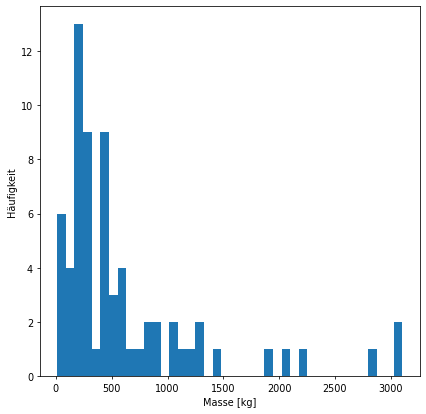

In [8]:
genHist(df1["Masse [kg]"], "Masse [kg]")

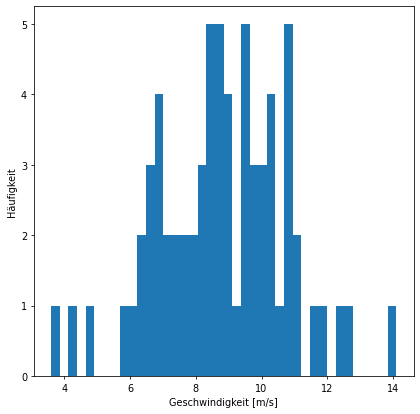

In [9]:
genHist(df1["Geschwindigkeit [m/s]"], "Geschwindigkeit [m/s]")

#### Ablösungszone 2

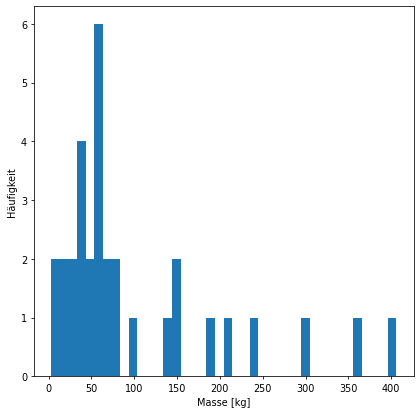

In [10]:
genHist(df2["Masse [kg]"], "Masse [kg]")

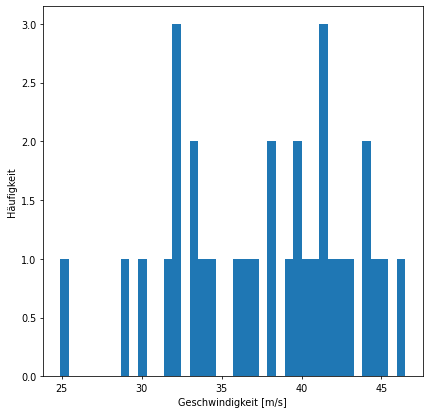

In [11]:
genHist(df2["Geschwindigkeit [m/s]"], "Geschwindigkeit [m/s]")

### 3.2 Streudiagramme

#### Ablösungszone 1

In [12]:
def genScatter(data_x, data_y, label_x, label_y, lim_x, lim_y):
    plt.figure(figsize=(8, 8), dpi= 70, facecolor="w", edgecolor="k")

    plt.scatter(data_x, data_y)

    plt.gca().set(xlim=(0.0, lim_x), ylim=(0, lim_y), xlabel=label_x, ylabel=label_y)

    plt.title("Scatterplot von {} vs {}".format(label_x, label_y), fontsize=20)
    plt.legend(fontsize=12)    
    plt.show()    

No handles with labels found to put in legend.


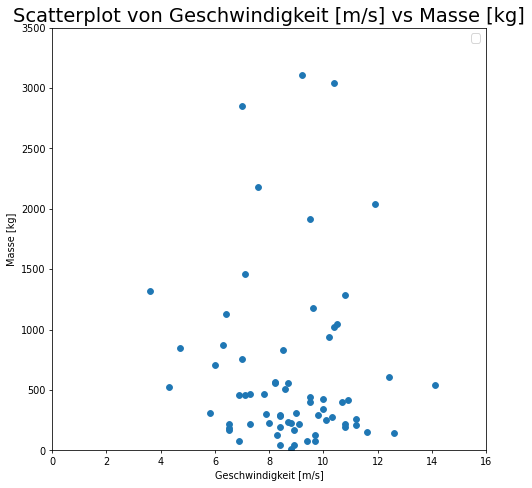

In [13]:
genScatter(df1["Geschwindigkeit [m/s]"], df1["Masse [kg]"], "Geschwindigkeit [m/s]", "Masse [kg]", 16, 3500)

#### Ablösungszone 2

No handles with labels found to put in legend.


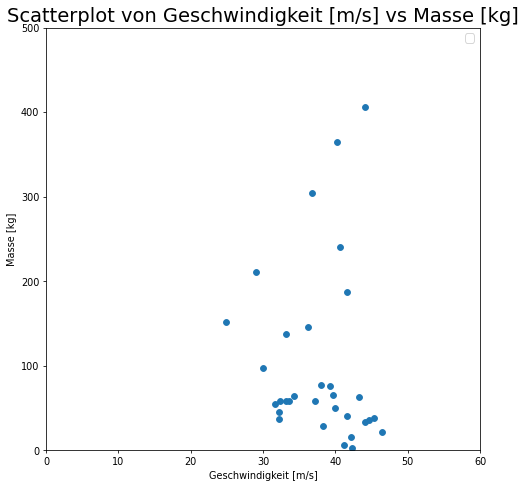

In [14]:
genScatter(df2["Geschwindigkeit [m/s]"], df2["Masse [kg]"], "Geschwindigkeit [m/s]", "Masse [kg]", 60, 500)

### 3.3 Vergleich Ablösungszone 1 und 2

#### Tabellen zusammenfügen

In [15]:
df3 = pd.concat([df1, df2], ignore_index=True)

#### 3.3.1 Histogramm Masse

In [16]:
def genGroupedHist(dataframe, x_var):
    # Prepare data
    groupby_var = "Ablösungszone"
    df_agg = dataframe.loc[:, [x_var, groupby_var]].groupby(groupby_var)
    vals = [dataframe[x_var].values.tolist() for i, dataframe in df_agg]

    # Draw
    plt.figure(figsize=(16,9), dpi= 80)
    colors = [plt.cm.Spectral(i/float(len(vals)-1)) for i in range(len(vals))]
    n, bins, patches = plt.hist(vals, 30, stacked=True, density=False, color=colors[:len(vals)])

    # Decoration
    plt.legend({group:col for group, col in zip(np.unique(dataframe[groupby_var]).tolist(), colors[:len(vals)])})
    plt.title(f"Stacked Histogram of ${x_var}$ colored by ${groupby_var}$", fontsize=22)
    plt.xlabel(x_var)
    plt.ylabel("Frequency")
    plt.ylim(0, 25)
    plt.xticks(ticks=bins[::3], labels=[round(b,1) for b in bins[::3]])
    plt.show()

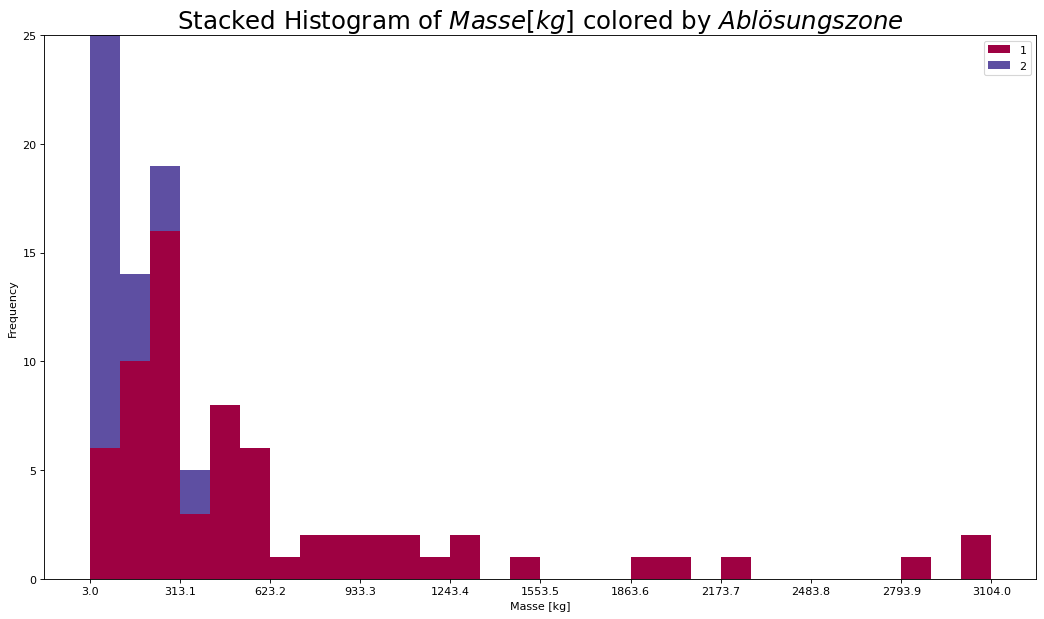

In [17]:
genGroupedHist(df3, "Masse [kg]")

#### 3.3.2 Histogramm Geschwindigkeit

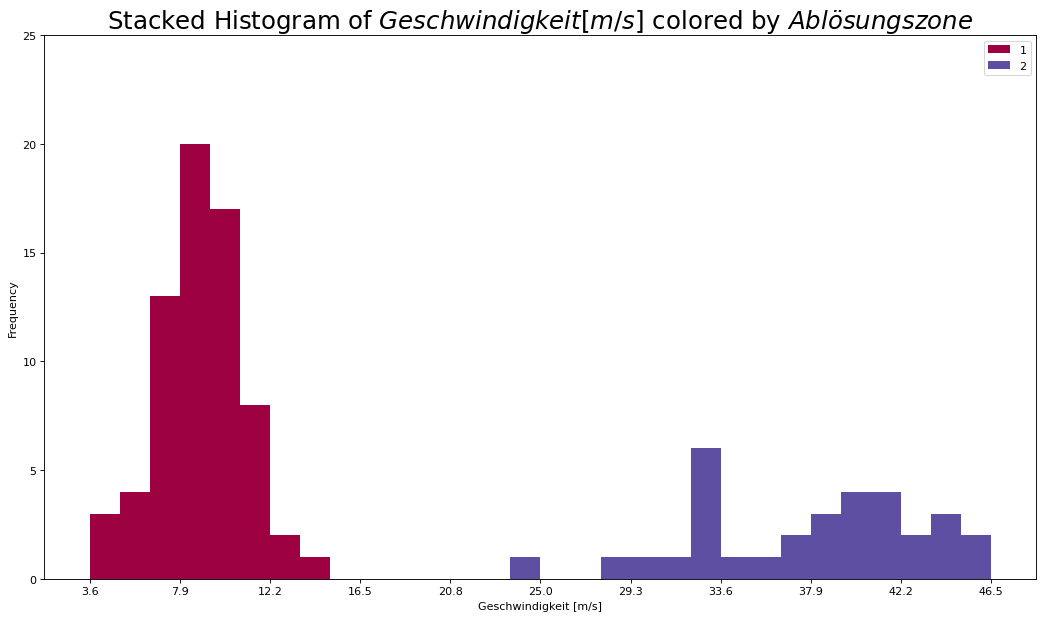

In [18]:
genGroupedHist(df3, "Geschwindigkeit [m/s]")

#### 3.3.3 Streudiagramm

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


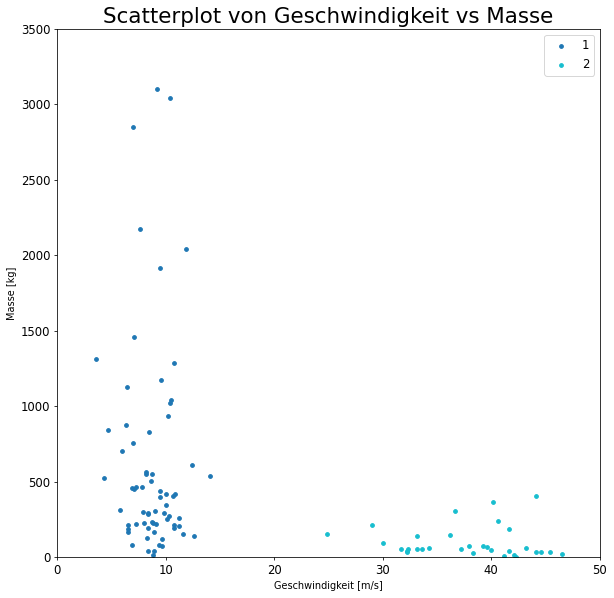

In [19]:
# Create as many colors as there are unique df3['ablösungszone']
categories = np.unique(df3['Ablösungszone'])
colors = [plt.cm.tab10(i/float(len(categories)-1)) for i in range(len(categories))]

# Draw Plot for Each Category
plt.figure(figsize=(10, 10), dpi= 70, facecolor='w', edgecolor='k')

for i, category in enumerate(categories):
    plt.scatter('Geschwindigkeit [m/s]', 'Masse [kg]', 
                data=df3.loc[df3.Ablösungszone == category, :], 
                s=15, c=colors[i], label=str(category))

plt.gca().set(xlim=(0.0, 50), ylim=(0, 3500), xlabel='Geschwindigkeit [m/s]', ylabel='Masse [kg]')

plt.xticks(fontsize=12); plt.yticks(fontsize=12)
plt.title("Scatterplot von Geschwindigkeit vs Masse", fontsize=22)
plt.legend(fontsize=12)    
plt.show()

#### 3.3.4 Bemerkungen

Ablösungszone 1 und 2 sollte man nicht kombinieren, weil die Datensätze stark unterschiedlich sind. Wir nehmen an, dass Ablösungszone 2 steiler ist als Zone 1, aufgrund von der Geschwindigkeit. Bei Ablösungszone 1 befinden sich deutlich massenhaftere Steine als bei Zone 2.

### 3.4 Statistik

In [20]:
df1.describe()

,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
count,68.000000,68.000000,68.0
mean,628.632353,8.788235,1.0
std,695.884703,1.989189,0.0
min,12.000000,3.600000,1.0
25%,214.750000,7.300000,1.0
50%,402.500000,8.800000,1.0
75%,773.000000,10.125000,1.0
max,3104.000000,14.100000,1.0


In [21]:
df2.describe()

,Masse [kg],Geschwindigkeit [m/s],Ablösungszone
count,32.000000,32.000000,32.0
mean,101.062500,37.790625,2.0
std,102.785382,5.395778,0.0
min,3.000000,24.900000,2.0
25%,37.750000,33.200000,2.0
50%,58.000000,38.750000,2.0
75%,140.000000,41.725000,2.0
max,406.000000,46.500000,2.0


## 4. Berechnungen

### 4.1 Kinetische Energie
Hier wird die kinetische Energie von jedem Steinschlag berechnet und zu einer Liste hinzugefügt. Danach wird diese Liste als Spalte in df3 ergänzt.

In [22]:
def calcEnergy(data):
    list_kg = [(x) for x in data["Masse [kg]"]]
    list_ms = [(x) for x in data["Geschwindigkeit [m/s]"]]
    list_kj = [] 

    for i in range(len(list_kg)):
        kj = 0.5 * list_kg[i] * list_ms[i]**2 / 1000
        kj = round(kj,1)
        list_kj.append(kj)

    return list_kj   

In [23]:
kj_zone_1 = calcEnergy(df1)

In [24]:
kj_zone_2 = calcEnergy(df2)

### 4.2 Durchschnitt der Massen berechnen

### 4.3 Zeitbstand von Steinschlägen berechnen
Wir berechnen jetzt die Zeitabstände in Stunden von den Steinschlägen damit wir eine Normalverteilung aufstellen können.

In [25]:
from pandas._libs.tslibs.timestamps import Timestamp

In [26]:
# Convert 'pandas._libs.tslibs.timestamps.Timestamp' to 'datetime.datetime'
def convertToDatetime(data):
    date_times = []
    
    for i in data["Datum"]:
        ts = Timestamp(i, freq='MS')
        date_time = ts.to_pydatetime()
        date_times.append(date_time)
        
    return date_times

In [27]:
def calcDiffTimes(data):
    diff_times = []
    days = 0

    date_times = convertToDatetime(data)

    # Calculate time differences 
    for i in range(len(date_times)):
        # Check index out of bounds:
        if(i < (len(date_times) - 1)):
            diff = date_times[i+1] - date_times[i]
            diff_times.append(diff)
            
    return diff_times

In [28]:
times_zone1 = calcDiffTimes(df1)
times_zone2 = calcDiffTimes(df2)

In [29]:
def calcAverage(lst, i):
    return round(sum(lst) / float(len(lst)-i),1)

In [30]:
def calcTimeDistance(zone):
    time_distances = []
    for i in range(len(zone)):
        try: 
            distance = int(abs(zone[i] - zone[i+1]).total_seconds() / 3600)
            time_distances.append(distance)
        except Exception:
            pass 
        
    return time_distances

In [31]:
# Create lists with times
dates_zone1 = list(i for i in df1["Datum"])
dates_zone2 = list(i for i in df2["Datum"])

# Calculate time between each rockfall for zone 1 & 2
time_dist_zone1 = calcTimeDistance(dates_zone1)
time_dist_zone2 = calcTimeDistance(dates_zone2)

print("Zeitabstände von Steinschlägen in Stunden:")
print("Ablösungszone 1: {}".format(time_dist_zone1))
print("Ablösungszone 2: {}".format(time_dist_zone2))

avg_time_dist_zone1 = calcAverage(time_dist_zone1, 0)
avg_time_dist_zone2 = calcAverage(time_dist_zone2, 0)

print("Durchschnittlicher Zeitabstand von Steinschlägen in Stunden:")
print("Ablösungszone 1: {}".format(avg_time_dist_zone1))
print("Ablösungszone 2: {}".format(avg_time_dist_zone2))

Zeitabstände von Steinschlägen in Stunden:
Ablösungszone 1: [12, 17, 49, 32, 65, 42, 22, 48, 45, 57, 4, 7, 50, 77, 2, 4, 12, 2, 24, 40, 14, 102, 59, 33, 15, 1, 34, 46, 0, 35, 5, 40, 21, 68, 5, 39, 3, 15, 58, 11, 60, 8, 1, 49, 19, 6, 64, 4, 2, 24, 50, 59, 4, 5, 65, 6, 19, 7, 22, 1, 113, 0, 28, 98, 78, 6, 34]
Ablösungszone 2: [45, 28, 76, 88, 10, 67, 39, 52, 35, 29, 13, 34, 154, 187, 114, 81, 30, 31, 212, 63, 7, 177, 67, 7, 19, 135, 73, 27, 75, 22, 59]
Durchschnittlicher Zeitabstand von Steinschlägen in Stunden:
Ablösungszone 1: 30.6
Ablösungszone 2: 66.3


In [32]:
# Spalte Zeitabstand hinzufügen
df_Zeitabstand_1 = pd.DataFrame(time_dist_zone1)
df_Zeitabstand_2 = pd.DataFrame(time_dist_zone2)

df_Zeitabstand_1

,0
0,12
1,17
2,49
3,32
4,65
...,...
62,28
63,98
64,78
65,6


## 5. Wahrscheinlichkeitsverteilungen (Zufallsvariablen)

### 5.1 Wahrscheinlichkeits Dichteplot (PDF)

In [33]:
def densityPlot(dataframe, x_val):
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data=dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)
    vals = dataframe[x_val].values
    
    fitter_vals = Fitter(vals, distributions=["norm"])
        
    """
    fitter_vals = Fitter(vals,
               distributions=['alpha',
                              'beta',
                              "gamma",
                              "norm",
                              "expon",
                              "lognorm",
                              "chi2",
                              "genhyperbolic"])
    """
    
    fitter_vals.fit()
    fitter_vals.summary()
    norms = fitter_vals.fitted_param["norm"]
    
    return norms

In [34]:
def best_distribution(dataframe, x_val):
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data=dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)
    vals = dataframe[x_val].values
    
    fitter_vals = Fitter(vals, distributions=get_common_distributions())
    fitter_vals.fit()
    fitter_vals.summary()
    return fitter_vals.get_best(method = 'sumsquare_error')

In [35]:
def expon_distribution(dataframe, x_val):
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data=dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)
    vals = dataframe[x_val].values
    
    fitter_vals = Fitter(vals, distributions=["expon"])
        
    """
    fitter_vals = Fitter(vals,
               distributions=['alpha',
                              'beta',
                              "gamma",
                              "norm",
                              "expon",
                              "lognorm",
                              "chi2",
                              "genhyperbolic"])
    """
    
    fitter_vals.fit()
    fitter_vals.summary()
    return fitter_vals.fitted_param["expon"]

#### Ablösungszone 1

{'cauchy': {'loc': 313.1732540199847, 'scale': 188.98367020559948}}


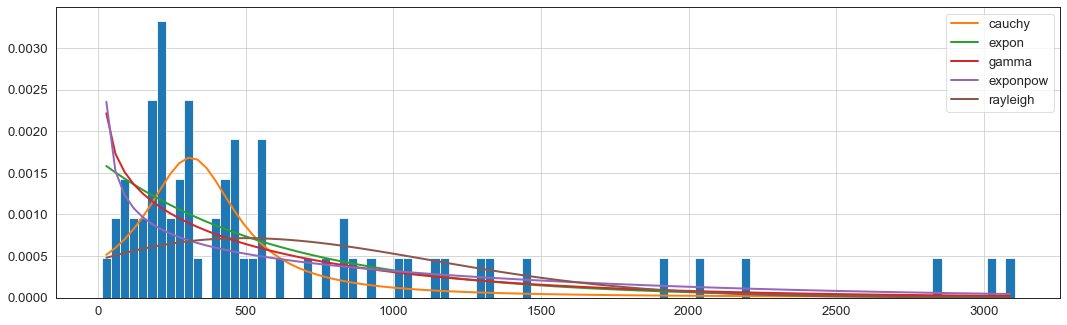

In [36]:
# Masse
distribution_mass1_param = best_distribution(df1, "Masse [kg]")
print(distribution_mass1_param)

{'norm': {'loc': 8.788235294117646, 'scale': 1.9745088303442118}}


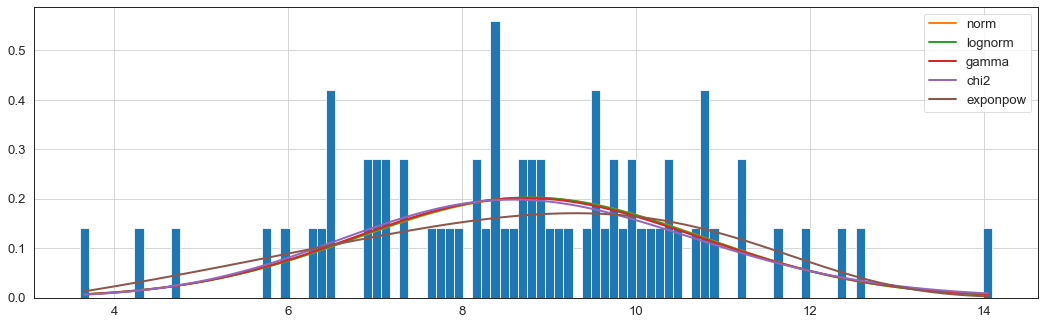

In [37]:
# Geschwindigkeit
distribution_speed1_param = best_distribution(df1, "Geschwindigkeit [m/s]")
print(distribution_speed1_param)

{'gamma': {'a': 0.7720943018929209, 'loc': -2.1070777126863917e-25, 'scale': 32.180388904581854}}


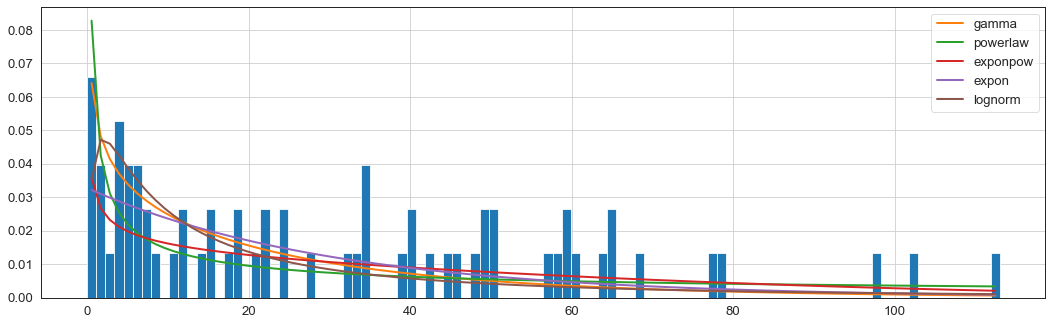

In [38]:
# Zeitabstand
distribution_time1_param = best_distribution(df_Zeitabstand_1, 0)
print(distribution_time1_param)

#### Ablösungszone 2

{'cauchy': {'loc': 52.76182227525061, 'scale': 24.885448181743413}}


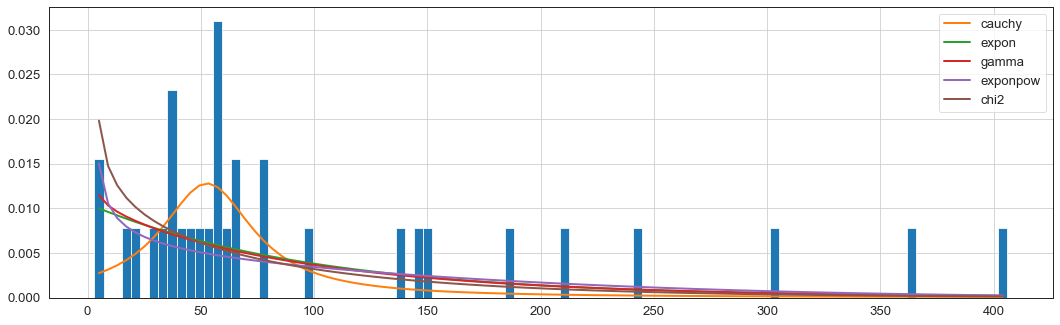

In [39]:
# Masse
distribution_mass2_param = best_distribution(df2, "Masse [kg]")
print(distribution_mass2_param)

{'powerlaw': {'a': 1.6225211698026003, 'loc': 24.037051269746893, 'scale': 22.46294873394062}}


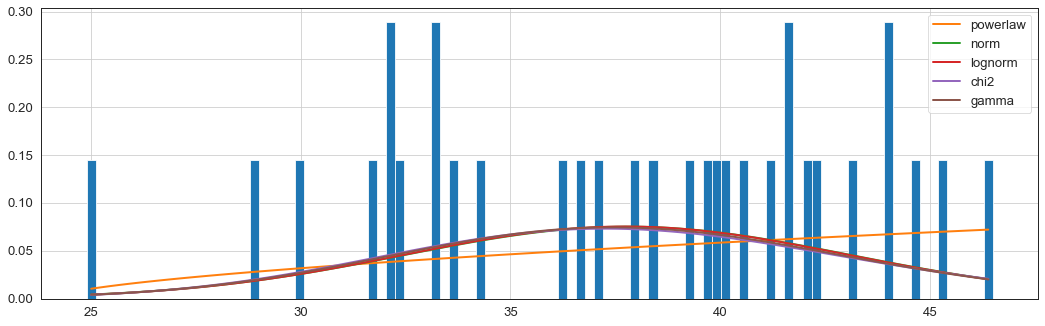

In [40]:
# Geschwindigkeit
distribution_speed2_param = best_distribution(df2, "Geschwindigkeit [m/s]")
print(distribution_speed2_param)

(7.0, 59.322580645161295)


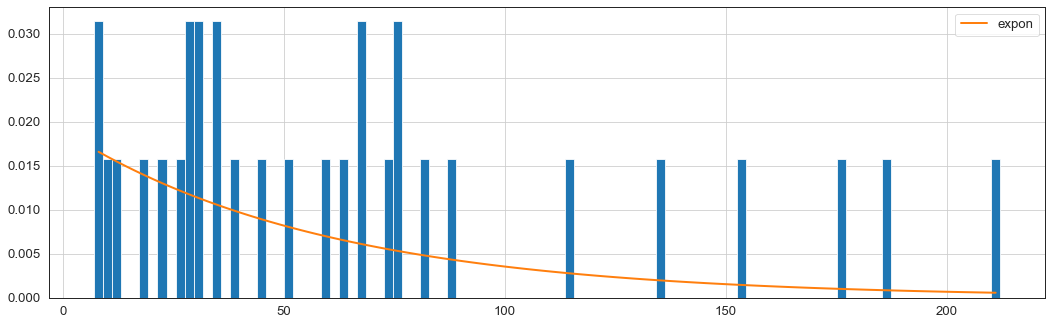

In [41]:
# Zeitabstand
distribution_time2_param = expon_distribution(df_Zeitabstand_2, 0)
print(distribution_time2_param)

### 5.2 Kummultative Funktionsverteilung (CDF)

#### Ablösungszone 1

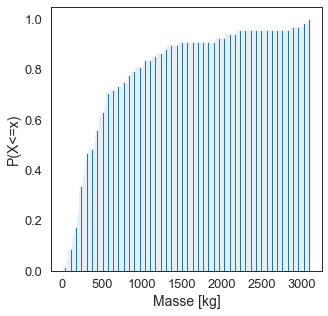

In [42]:
plt.figure(figsize=(5, 5), dpi= 70, facecolor='w', edgecolor='k')
plt.hist(df1["Masse [kg]"], cumulative=True, density=True, bins=200)
plt.ylabel("P(X<=x)")
plt.xlabel("Masse [kg]");

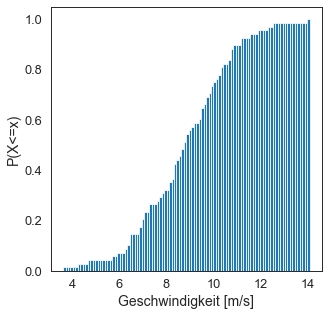

In [43]:
plt.figure(figsize=(5, 5), dpi= 70, facecolor='w', edgecolor='k')
plt.hist(df1['Geschwindigkeit [m/s]'], cumulative=True, density=True, bins=100)
plt.ylabel("P(X<=x)")
plt.xlabel('Geschwindigkeit [m/s]');

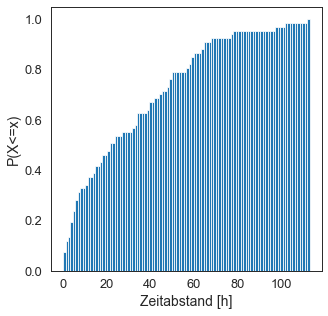

In [44]:
plt.figure(figsize=(5, 5), dpi= 70, facecolor='w', edgecolor='k')
plt.hist(df_Zeitabstand_1[0], cumulative=True, density=True, bins=100)
plt.ylabel("P(X<=x)")
plt.xlabel('Zeitabstand [h]');

#### Ablösungszone 2

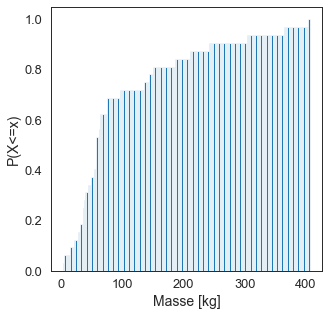

In [45]:
plt.figure(figsize=(5, 5), dpi= 70, facecolor='w', edgecolor='k')
plt.hist(df2["Masse [kg]"], cumulative=True, density=True, bins=200)
plt.ylabel("P(X<=x)")
plt.xlabel("Masse [kg]");

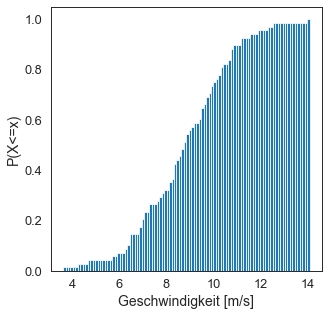

In [46]:
plt.figure(figsize=(5, 5), dpi= 70, facecolor='w', edgecolor='k')
plt.hist(df1['Geschwindigkeit [m/s]'], cumulative=True, density=True, bins=100)
plt.ylabel("P(X<=x)")
plt.xlabel('Geschwindigkeit [m/s]');

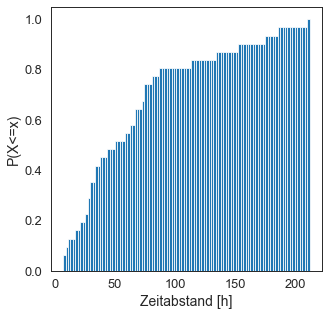

In [47]:
plt.figure(figsize=(5, 5), dpi= 70, facecolor='w', edgecolor='k')
plt.hist(df_Zeitabstand_2[0], cumulative=True, density=True, bins=100)
plt.ylabel("P(X<=x)")
plt.xlabel('Zeitabstand [h]');

## 6. Simulation von Masse, Geschwindigkeit und Zeit

In [48]:
# Anzahl Daten für die Simulationen
sim_size = 1000000

In [49]:
def plotDistr(dataframe, x_val):
    sns.set_style('white')
    sns.set_context("paper", font_scale = 1.5)
    sns.displot(data = dataframe, x = x_val, kind = "hist", bins = 150, aspect = 3.0)   

### 6.1 Ablösungszone 1

#### 6.1.1 Masse

628.6323529411765
616.8812377753297


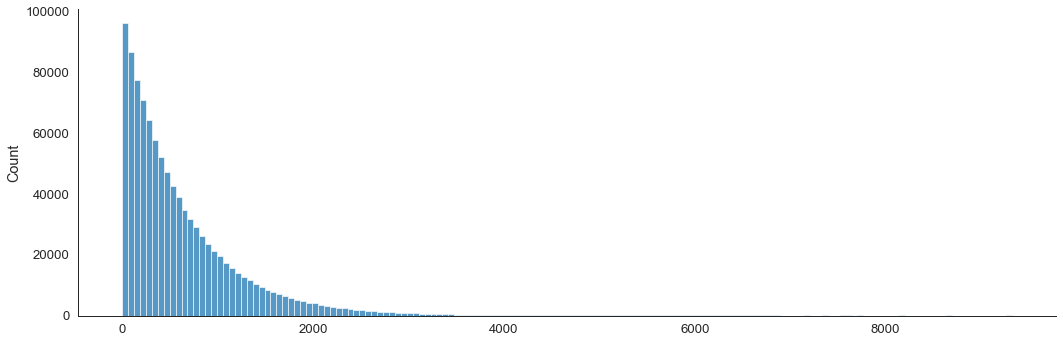

In [50]:
# (12.0, 616.6323529411765)
shape, scale = 12.0, 616.6323529411765
sim_mass_zone1 = np.random.exponential(scale, sim_size)

df_sim_mass_zone1 = pd.DataFrame(sim_mass_zone1)

plotDistr(df_sim_mass_zone1, sim_mass_zone1)

# Test
print(np.mean(df1["Masse [kg]"]))
print(np.mean(df_sim_mass_zone1[0]))
# Immer sehr weit auseinander

#### 6.1.2 Geschwindigkeit

8.788235294117646
8.79021179818277


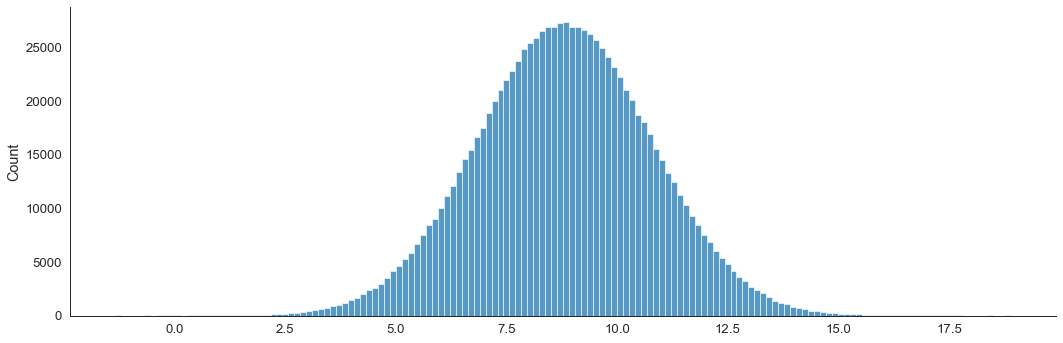

In [51]:
# {'norm': {'loc': 8.788235294117646, 'scale': 1.9745088303442118}}
shape, scale = 8.788235294117646, 1.9745088303442118
sim_speed_zone1 = np.random.normal(shape, scale, sim_size)

df_sim_speed_zone1 = pd.DataFrame(sim_speed_zone1)

plotDistr(df_sim_speed_zone1, sim_speed_zone1)

# Test
print(np.mean(df1["Geschwindigkeit [m/s]"]))
print(np.mean(df_sim_speed_zone1[0]))

#### 6.1.3 Zeit

30.55223880597015
24.8189026739875


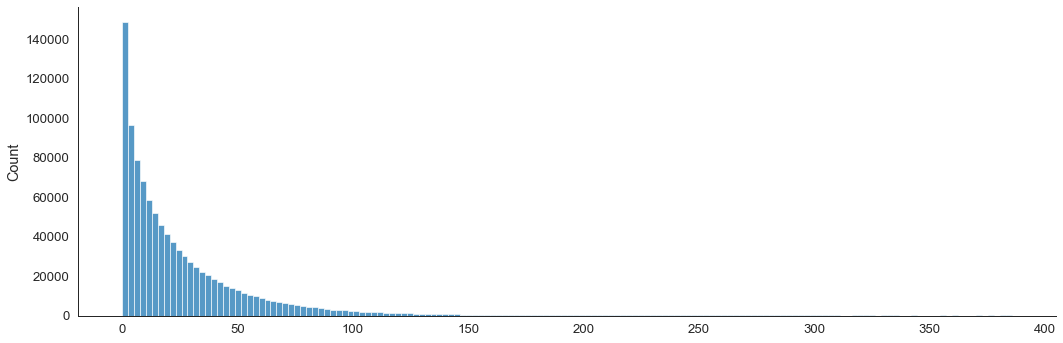

In [52]:
# {'gamma': {'a': 0.7720943018929209, 'loc': -2.1070777126863917e-25, 'scale': 32.180388904581854}}
shape, scale = 0.7720943018929209, 32.180388904581854
sim_time_zone1 = np.random.gamma(shape, scale, sim_size)

df_sim_time_zone1 = pd.DataFrame(sim_time_zone1)

plotDistr(df_sim_time_zone1, sim_time_zone1)

# Test
print(np.mean(df_Zeitabstand_1[0]))
print(np.mean(df_sim_time_zone1[0]))
# Immer recht weit auseinander

### 6.2 Ablösungszone 2

#### 6.2.1 Masse

101.0625
97.98891374044639


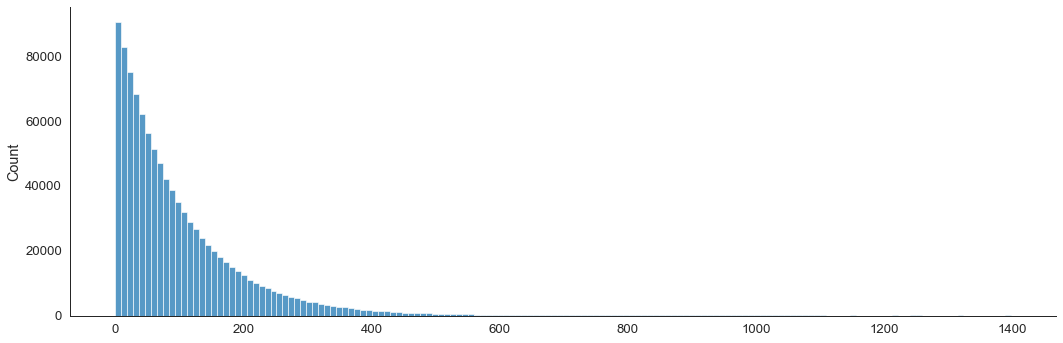

In [53]:
# (3.0, 98.0625)
shape, scale = 3.0, 98.0625
sim_mass_zone2 = np.random.exponential(scale, sim_size)

df_sim_mass_zone2 = pd.DataFrame(sim_mass_zone2)

plotDistr(df_sim_mass_zone2, sim_mass_zone2)

# Test
print(np.mean(df2["Masse [kg]"]))
print(np.mean(df_sim_mass_zone2[0]))
# Immer um 3-4 auseinander

#### 6.2.2 Geschwindigkeit

37.790625000000006
36.479686856723674


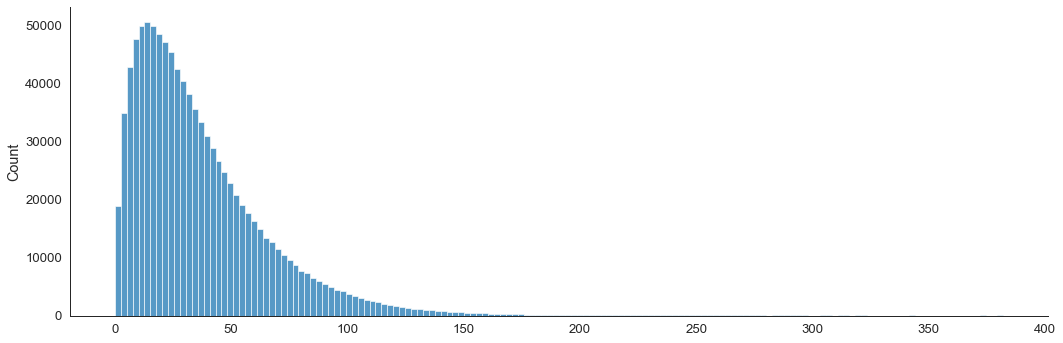

In [54]:
# {'powerlaw': {'a': 1.6225211698026003, 'loc': 24.037051269746893, 'scale': 22.46294873394062}}
shape, scale = 1.6225211698026003, 22.46294873394062
sim_speed_zone2 = np.random.gamma(shape, scale, sim_size)

df_sim_speed_zone2 = pd.DataFrame(sim_speed_zone2)

plotDistr(df_sim_speed_zone2, sim_speed_zone2)

# Test
print(np.mean(df2["Geschwindigkeit [m/s]"]))
print(np.mean(df_sim_speed_zone2[0]))

#### 6.2.3 Zeit

66.3225806451613
117.31711043427323


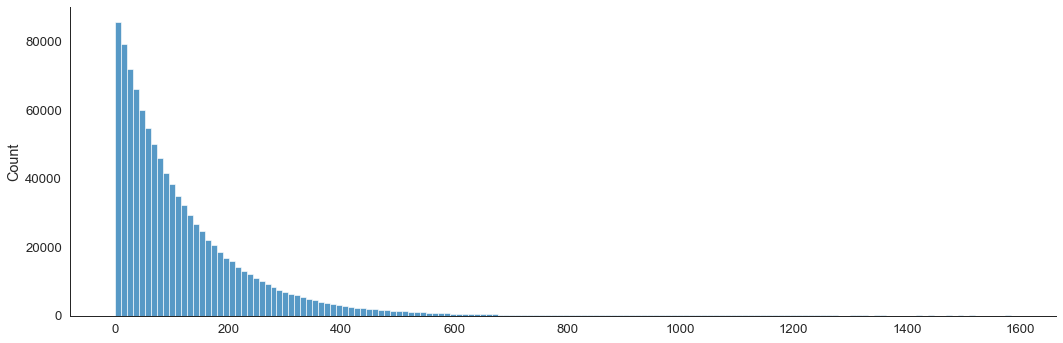

In [61]:
# {'exponpow': {'b': 0.6971027826831848, 'loc': 6.999999999999999, 'scale': 117.24076793057438}}
# expon: (7.0, 59.322580645161295)

shape, scale = 0.6971027826831848, 117.24076793057438
sim_time_zone2 = np.random.exponential(scale, sim_size)

df_sim_time_zone2 = pd.DataFrame(sim_time_zone2)

plotDistr(df_sim_time_zone2, sim_time_zone2)

# Test
print(np.mean(df_Zeitabstand_2[0]))
print(np.mean(df_sim_time_zone2[0]))
# Immer sehr weit auseinander

### 6.3 Dataframe der Simulationen

Hier fügen wir die Daten aus der Simulationen in einem Dataframe zusammen. Dazu werden noch die Zeilenbeschriftungen umbenennt.

In [56]:
# Simulierte Masse, Geschwindigkeit, Zeit zusammenfügen
df_simulation_zone1 = pd.concat([df_sim_mass_zone1, df_sim_speed_zone1, df_sim_time_zone1], axis=1, join="inner")
df_simulation_zone1.columns = ["Masse [kg]", "Geschwindigkeit [m/s]", "Zeitabstand [h]"]

df_simulation_zone2 = pd.concat([df_sim_mass_zone2, df_sim_speed_zone2, df_sim_time_zone2], axis=1, join="inner")
df_simulation_zone2.columns = ["Masse [kg]", "Geschwindigkeit [m/s]", "Zeitabstand [h]"]

In [57]:
df_simulation_zone1

,Masse [kg],Geschwindigkeit [m/s],Zeitabstand [h]
0,154.103231,8.805816,25.422745
1,11.377106,10.118118,1.178057
2,547.856401,11.649539,26.175425
3,204.332009,12.319714,28.600150
4,736.312763,10.319139,2.343019
...,...,...,...
999995,223.441175,10.264009,57.717953
999996,193.555553,7.681040,1.099551
999997,897.124133,5.363338,5.126013
999998,200.995162,8.992780,3.762190


In [58]:
df_simulation_zone2

,Masse [kg],Geschwindigkeit [m/s],Zeitabstand [h]
0,14.149084,94.248646,75.040096
1,55.443671,8.986001,1.034076
2,46.111044,82.297464,23.649309
3,39.769556,23.123364,26.242922
4,44.636472,52.428652,30.048579
...,...,...,...
999995,24.602194,66.392833,12.314597
999996,50.222703,40.527812,24.106466
999997,60.851821,98.079750,50.130350
999998,7.036635,38.801426,24.613755


## 7. Netz
Netz Falls bereits ein Stein mit über 2000kg in den Sicherheitsnetzen liegt, beträgt die Aufprallenergie, die von den Sicherheitsnetzen aufgenommen werden kann, nur noch 500 kJ. Steine in den Sicherheitsnetze werden vom Unterhaltsteam entfernt (die Reaktionszeit beträgt 24 Stunden).

- Nach Tag Gruppieren, und Summe der Masse im Netz finden. 
- An wie vielen Tagen, hatte das Netz 2000 kg Steine? 
- Was passiert wenn das Netz reist? 
- Wahrscheinlichkeit, dass im Netz 2000 kg sind, gesehen ueber Messzeit. 
- Wahrscheinlickeitm, dass ein Stein mit 500 kj herunterfiel.
- Wann werden die Netze geleert?

## 8. Verkehr
Das tägliche Verkehrsaufkommen beträgt 1200 Autos. Stau kommt auf der Strecke nicht vor. Die Tempolimite beträgt 60 km/h.
- Wie viele Autos fahren täglich durch?
- Mit welcher Geschwindigkeit?
- Welche Art von Fahrzeugen (PKW, LKW, Töff...)
- Sieht der fahrer den Steinschlag? Kann er bremsen?

## 9. Wahrscheinlichkeitsberechnungen

Monte Carlo Simultaion

## 10. Fazit / Bericht